In [60]:
import utils as u
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib widget

with open('modal_plexi.pkl', 'rb') as f:
    modal_analysis_plexi = pickle.load(f)

with open('modal_m2.pkl', 'rb') as f:
    modal_analysis_m2 = pickle.load(f)

with open('modal_m1.pkl', 'rb') as f:
    modal_analysis_m1 = pickle.load(f)

with open('modal_metal.pkl', 'rb') as f:
    modal_analysis_metal = pickle.load(f)

In [61]:
Lx = 0.40
Ly = 0.26

h_metal = 6.01e-3
E_nu_metal = 7291666666
masse_metal = 1588e-3
rho_metal = masse_metal / (Lx * Ly * h_metal)

h_m2 = 6.04e-3 
E_nu_m2 = 7291666666
masse_m2 = 507e-3
rho_m2 =masse_m2 / (Lx * Ly * h_m2)

h_m1 = 2.95e-3 
E_nu_m1 = 7291666666
masse_m1 = 236e-3
rho_m1 = masse_m1 / (Lx * Ly * h_m1)

h_plexi = 4.51e-3
E_nu_plexi = 7291666666 
masse_plexi = 382e-3
rho_plexi = masse_plexi / (Lx * Ly * h_plexi)

In [63]:
def omega_pq (p,q,h,E_nu,rho,Lx,Ly) :    #Calcul analytique des pulsations propres d'une plaque en appuis simple
    return np.sqrt(E_nu*h**2/(12*rho)) * ((p*np.pi/Lx)**2+(q*np.pi/Ly)**2)

def phi_pq (p,q,x,y, Lx, Ly) :  #Calcul analytique des déformées des modes d'une plaque en appuis simple
    """
    ## Inputs
    - p : numéro du mode selon x
    - q : numéro du mode selon y
    - x : arrayLike, vecteur des abscisses
    - y : arrayLike, vecteur des ordonnées

    ## Outputs
    - phi_pq : arrayLike, size (Nx,Ny), déformée du mode (p,q) en tous les points (x,y) du maillage
    """
    return np.sin(p*np.pi*x[:,np.newaxis]/Lx)*np.sin(q*np.pi*y[np.newaxis,:]/Ly)

def f_plaque(Lx,Ly,h,E_nu,rhoT):
    NB, MB = 3, 3 #Nombre de modes selon x, y
    NmB = NB * MB   #Nombre de modes total considéré dans le modèle de plaque

    dx, dy = 10e-3, 10e-3
    x, y = np.arange(0,Lx,dx), np.arange(0,Ly,dy)
    Nx, Ny = len(x), len(y)
    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m, h, E_nu,rhoT,Lx,Ly)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant 

    return(wnB/2/np.pi)
def mode_plaque(Lx,Ly,h,E_nu,rhoT):
    NB, MB = 3, 3 #Nombre de modes selon x, y
    NmB = NB * MB   #Nombre de modes total considéré dans le modèle de plaque

    dx, dy = 10e-3, 10e-3
    x, y = np.arange(0,Lx,dx), np.arange(0,Ly,dy)
    Nx, Ny = len(x), len(y)
    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m, h, E_nu,rhoT,Lx,Ly)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant 
    NmB_idx = NmB_idx[:,tri_idx]      #On ordonne les modes par ordre croissant

    ### Déformées

    phiB_NxNy_NmB = np.zeros((Nx*Ny,NmB)) #Matrice des déformées avec les 2 dimensions spatiales applaties en 1 dimension
    phiB_Nx_Ny_NmB = np.zeros((Nx,Ny,NmB))
    for mode in range (NmB) :
        n, m = NmB_idx[0,mode], NmB_idx[1,mode]
        phiB_NxNy_NmB[:,mode] = phi_pq(n, m , x, y, Lx, Ly).ravel()
        phiB_Nx_Ny_NmB[:,:,mode] = phi_pq(n, m , x, y, Lx, Ly)

    MmB = np.zeros(NmB)
    for j in range(NmB) :
        PHI_j_Nx_Ny = phiB_Nx_Ny_NmB[:,:,j]    #Correspond à la déformée du mode j sur la plaque (en 2D)
        MmB[j] = rhoT * h * np.sum(np.sum(PHI_j_Nx_Ny**2,axis=1),axis=0) * dx * dy
    return(wnB/2/np.pi,phiB_NxNy_NmB,x,y,MmB)

##phiB_NxNy_NmB[:,j],(Nx,Ny)

In [64]:
f_base,phiB_NxNy_NmB,x,y,MmB = mode_plaque(Lx,Ly,h_metal,E_nu_metal,rho_metal)
Nx = len(x)
Ny = len(y)

In [65]:
X_che1 = 13 
Y_che1 = 8

X_che2 = 19
Y_che2 = 11

In [6]:
from data_loader import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


{'0': 'Metal', '1': 'Medium_1', '2': 'Plexi', '3': 'Medium_2'}


In [66]:
idx_mat = 0 #Je choisis le matériau d'indice 1

dico_pos1 = deforme_Nta_Npos[idx_mat,0]
dico_pos2 = deforme_Nta_Npos[idx_mat,1]

freq1 = dico_pos1['freq']
FRF1 = dico_pos1['FRF']

freq2 = dico_pos2['freq']
FRF2 = dico_pos2['FRF']

f_fond = modal_analysis_metal['freq']

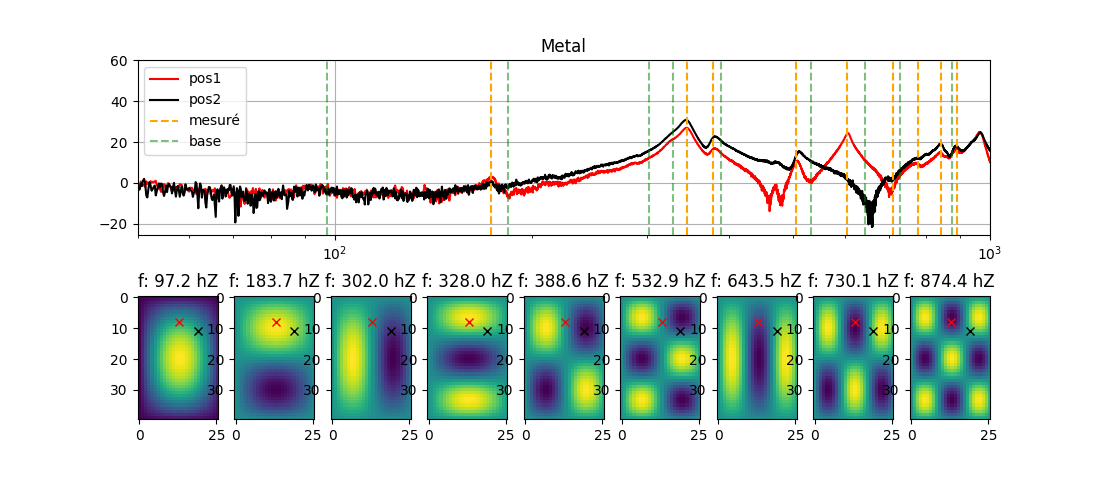

In [67]:
N_mode= 9
plt.figure(figsize=(11,5))
a1 = plt.subplot2grid((2,N_mode),(0,0),colspan = N_mode)
a1.semilogx(freq1,20*np.log10(np.abs(FRF1)),'r',label='pos1')
a1.semilogx(freq2,20*np.log10(np.abs(FRF2)),'k',label='pos2')
a1.set_title(dico_pos1["mat_table"])
a1.axvline(f_fond[0],ls='--',color='orange',label='mesuré')
a1.axvline(f_base[0],ls='--',color='green',label="base",alpha=0.5)
for i in range(1,min(len(f_fond),len(f_base))):
    a1.axvline(f_fond[i],ls='--',color='orange')
    a1.axvline(f_base[i],ls='--',color='green',alpha=0.5)

a1.grid()
a1.legend()
a1.set_xlim(50,1000)
for i in range(N_mode):
    ax = plt.subplot2grid((2,N_mode),(1,i),rowspan = 1, colspan = 1)
    ax.imshow(np.reshape(phiB_NxNy_NmB[:,i],(Nx,Ny)))
    ax.plot(X_che1,Y_che1,'rx',label='pos1')
    ax.plot(X_che2,Y_che2,'kx',label='pos2')
    ax.set_title(f'f: {f_base[i]:0.1f} hZ')
plt.show()

In [84]:
f_bon = [f_fond[0],f_fond[1],f_fond[2],471,f_fond[3]]
#f_bon = [f_fond[0],f_fond[1],f_fond[2],f_fond[4]]
print(f_bon)

[173, 345, 378, 471, 506]


In [88]:
def optimisation(f_bon,h,E_nu,rhoT,Lx,Ly,plot=True):
    pourcentage = 0.3
    idx_max = len(f_bon)
    XX = np.linspace(Lx*(1 - pourcentage),Lx*(1+pourcentage),100)
    YY = np.linspace(Ly*(1 - pourcentage),Ly*(1+pourcentage),80)
    cout = np.zeros((len(XX),len(YY)))

    pondération = [30,15,5]
    pondération = np.concatenate((pondération,[1]*(len(f_bon)-3)))

    for ii,i in enumerate(XX) :
        for jj,j in enumerate(YY):
            f_optim = f_plaque(i,j,h,E_nu,rhoT)
            cout[ii,jj] = np.sum(np.abs(pondération * (f_bon - f_optim[:idx_max])))
            

    xxx, yyy=  np.unravel_index(cout.argmin(), cout.shape)
    Lx_final, Ly_final = XX[xxx],YY[yyy]
    if plot :
        extent = np.min(XX), np.max(XX), np.min(YY), np.max(YY)
        plt.figure()        
        plt.scatter(XX[xxx],YY[yyy],label="point choisi")
        plt.imshow(1-cout/np.max(cout),cmap='inferno',extent=extent)
        plt.xlabel("Variation en X")
        plt.ylabel("Variation en Y")
        plt.legend()
        plt.title("Fonction de cout en fonction des valeurs de X et de Y")
        plt.colorbar()
        plt.show()
        
    return(Lx_final, Ly_final,cout)

            


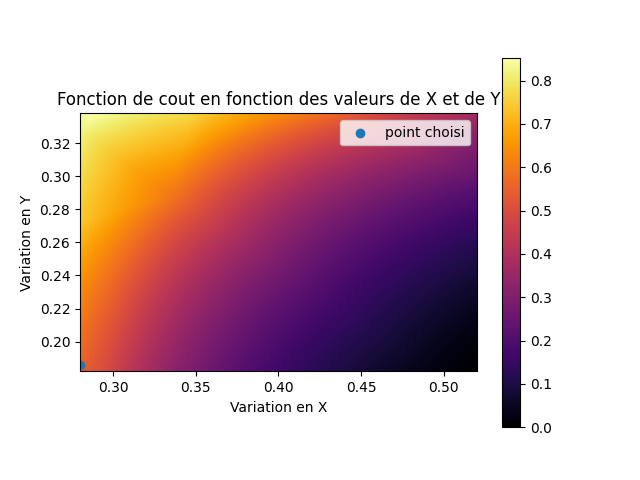

(0.27999999999999997, 0.1859493670886076)

In [89]:
Lx_op,Ly_op,cout = optimisation(f_bon,h_m1,E_nu_m1,rho_m1,Lx,Ly)
Lx_op,Ly_op

In [96]:
print(Ly_op)

0.1859493670886076


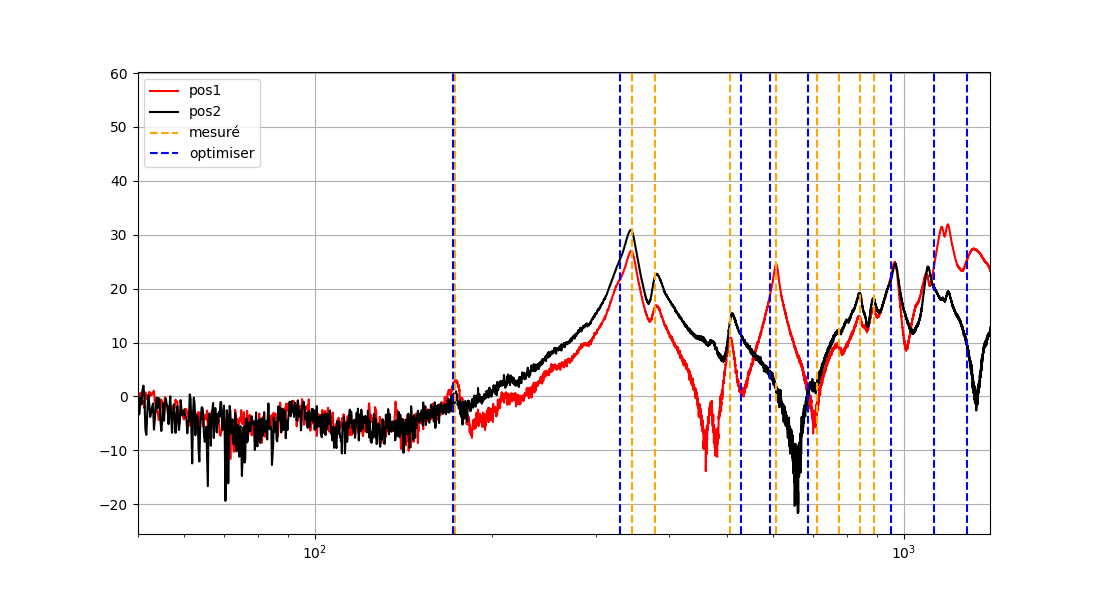

In [92]:
f_op = f_plaque(Lx_op, Ly_op,h_m1,E_nu_m1,rho_m1)
plt.figure(figsize = (11,6))
plt.semilogx(freq1,20*np.log10(np.abs(FRF1)),'r',label='pos1')
plt.semilogx(freq2,20*np.log10(np.abs(FRF2)),'k',label='pos2')
plt.axvline(f_fond[0],ls='--',color='orange',label = 'mesuré')
plt.axvline(f_op[0],ls='--',color='blue',label="optimiser")
#plt.axvline(f_base[0],ls='--',color='green',label="base",alpha=0.5)
for i in range(1,min(len(f_fond),len(f_base))):
    plt.axvline(f_fond[i],ls='--',color='orange')
    plt.axvline(f_op[i],ls='--',color='blue')
    #plt.axvline(f_base[i],ls='--',color='green',alpha=0.5)
plt.grid()
plt.legend()
plt.xlim(50,1400)
plt.show()

In [93]:
f_op

array([ 171.6412065 ,  329.23588248,  528.97015002,  591.89367579,
        686.564826  ,  949.2226193 , 1124.51838921, 1282.11306519,
       1544.7708585 ])

In [94]:
import pandas as pd 
pd.DataFrame(modal_analysis_metal)

,table,freq,xi,ratios,xi_mod
0,Metal,173,-0.000429,1.000000,-0.063436
1,Metal,345,-0.000814,1.994220,-0.060403
2,Metal,378,-0.000775,2.184971,-0.052469
3,Metal,506,-0.000819,2.924855,-0.041436
4,Metal,606,-0.000982,3.502890,-0.041484
5,Metal,711,-0.000600,4.109827,-0.021603
6,Metal,776,-0.001486,4.485549,-0.049023
7,Metal,842,-0.001408,4.867052,-0.042809
8,Metal,889,-0.001427,5.138728,-0.041092
9,Metal,967,-0.001286,5.589595,-0.034045


In [ ]:
[0.063436,0.060403,0.041436,0.041484,0.021603,0.034045,0.047832,0.039952,0.040259]